<a href="https://colab.research.google.com/github/selcancelikel/bitirmeprojesi/blob/main/AUTOENCODER11_26_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - loss: 0.3168 - val_loss: 0.2612
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.1971 - val_loss: 0.0644
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0586 - val_loss: 0.0513
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0517 - val_loss: 0.0480
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0492 - val_loss: 0.0466
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.0479 - val_loss: 0.0457
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0471 - val_loss: 0.0451
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0465 - val_loss: 0.0447
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0461 - val_loss: 0.0443
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.0457 - val_loss: 0.0441
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0454 - val_loss: 0.0438
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/

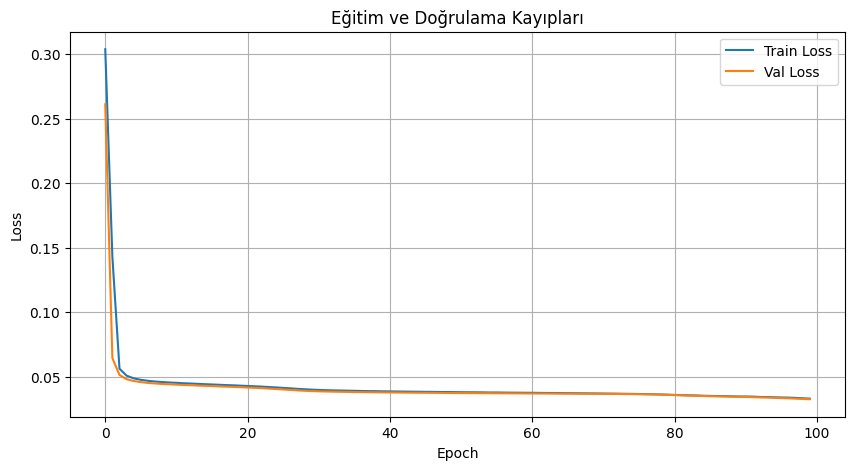

469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Anomali Eşiği: 0.05347
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15000
           1       0.95      1.00      0.97     15000

    accuracy                           0.97     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.97      0.97     30000

Confusion Matrix:
[[14250   750]
 [   21 14979]]
ROC AUC: 0.9996702799999999


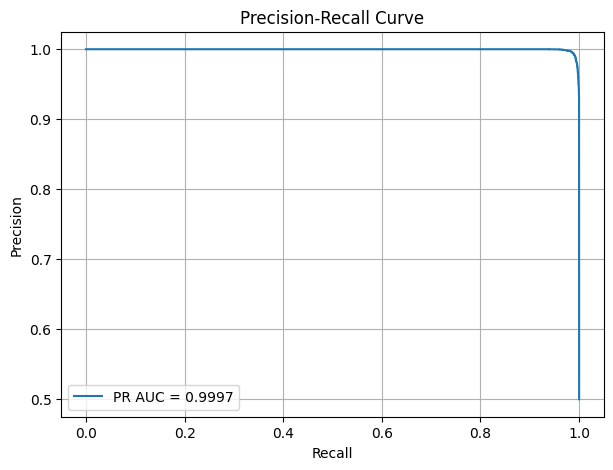

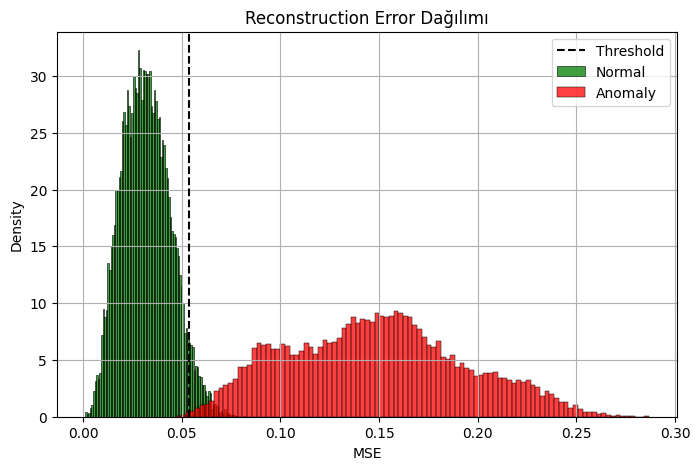

Model Accuracy: 97.43 %
İşlem tamamlandı: 2025-06-26 09:31:53


In [ ]:
# === GEREKLİ KÜTÜPHANELER ===
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# === LOGGING ve REPRODUCIBILITY ===
pd.set_option('display.max_columns', None)
tf.random.set_seed(42)
np.random.seed(42)

# === VERİYİ YÜKLE ===
df = pd.read_csv("balanced_logs_dense.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# === ZAMAN BİLGİLERİ VE İSTATİSTİKSEL ÖZNİTELİKLER ===
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['second'] = df['timestamp'].dt.second
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# === LABEL ENCODING ===
encoders = {}
for col in ['user', 'action', 'resource', 'status', 'ip_address']:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

# === ÖZNİTELİK VE ETİKET AYIRIMI ===
features = ['user', 'action', 'resource', 'status', 'ip_address', 'hour', 'minute', 'second', 'dayofweek', 'day', 'month', 'is_weekend']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
y = df['label'].values

# === LSTM GİRİŞİNE HAZIRLIK ===
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train = X_scaled[y == 0]  # Sadece normal örneklerle eğitim
X_test = X_scaled
y_test = y

# === MODEL MİMARİSİ ===
def build_lstm_autoencoder(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.4),
        layers.LSTM(128, return_sequences=False),
        layers.RepeatVector(1),
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.4),
        layers.LSTM(256, return_sequences=True),
        layers.TimeDistributed(layers.Dense(input_shape[1]))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')
    return model

model = build_lstm_autoencoder(X_train.shape[1:])
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# === MODEL EĞİTİMİ ===
history = model.fit(
    X_train, X_train,
    epochs=100,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    shuffle=True,
    verbose=1
)

# === EĞİTİM KAYBI GRAFİĞİ ===
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# === EŞİK SEÇİMİ ===
recon_train = model.predict(X_train)
mse_train = np.mean(np.mean(np.square(X_train - recon_train), axis=2), axis=1)
threshold = np.percentile(mse_train, 95)
print(f"Anomali Eşiği: {threshold:.5f}")

# === TAHMİN ===
recon_test = model.predict(X_test)
mse_test = np.mean(np.mean(np.square(X_test - recon_test), axis=2), axis=1)
y_pred = (mse_test > threshold).astype(int)

# === DOĞRULUK VE F1 SKOR ===
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, mse_test))

# === PRECISION-RECALL CURVE ===
precision, recall, _ = precision_recall_curve(y_test, mse_test)
auc_pr = auc(recall, precision)
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'PR AUC = {auc_pr:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

# === RECONSTRUCTION ERROR DAĞILIMI ===
plt.figure(figsize=(8, 5))
sns.histplot(mse_test[y_test == 0], bins=100, color='green', label='Normal', stat='density')
sns.histplot(mse_test[y_test == 1], bins=100, color='red', label='Anomaly', stat='density')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.legend()
plt.title("Reconstruction Error Dağılımı")
plt.xlabel("MSE")
plt.grid(True)
plt.show()

# === KAYIT ZAMANINI GÖSTER ===
print("Model Accuracy:", round((y_test == y_pred).mean() * 100, 2), "%")
print("İşlem tamamlandı:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
